## 1) 환경 설정 및 초기화
* tokenizer (한글 형태소 분석기) 설치
* 한글 글꼴 설치
* 설치 후 런타임 재시작 필요

* 이후 파일 로드; mac에서 저장한 xlsx 파일은 읽지 못함. xls파일로 저장하여 로드할 것

In [1]:
# tokenizer
!pip install konlpy

# hangul font
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 32.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 24 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,682 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back

In [2]:
!pwd
#!ls -al
!ls -al /content/drive/MyDrive/Colab\ Notebooks/nlp/kyobonlp
#MyDrive/Colab\ Notebooks/nlp/kyobonlp/trainingdata.xlsx

/content
total 152152
drwx------ 2 root root     4096 Dec 12 01:36 .git
-rw------- 1 root root 50697568 Dec 21  2016 ko.bin
-rw------- 1 root root 85362829 Dec 21  2016 ko.tsv
-rw------- 1 root root 19515078 Dec 14 10:36 ratings.txt
-rw------- 1 root root       38 Dec 12 01:36 README.md
-rw------- 1 root root    40214 Dec 12 03:47 trainingdata.csv
-rw------- 1 root root    91648 Dec 12 07:41 trainingdata.xls
-rw------- 1 root root    90318 Dec 21 04:27 word2vec.ipynb


In [3]:
# data import
import pandas as pd
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/trainingdata.xls")
df

,id,label,text
0,1,B,올해에는 많은 부서들이 예산보다 초과 지출했다.
1,2,B,그 사업을 위한 예산으로 1억원이 책정되어 있다
2,3,B,우리는 예산이 아주 빠듯하다
3,4,B,그 부서의 예산은 손댈 수 없다
4,5,B,우리가 올해는 예산보다 돈을 덜 썼다.
...,...,...,...
448,449,C,이 제품과 비교제품의 차이점을 자세히 알고 싶습니다.
449,450,C,이 제품은 비교제품에 비해 어떤 점이 더 다른가요?
450,451,C,제가 검토한 비교 제품과 이 제품을 비교해보면 어떤 차이가 있나요?
451,452,C,"비교제품 대비, 제가 이 제품을 구매해야 하는 이유가 무엇인가요?"


In [4]:
# preprocess; exclude special symbols
df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
df['text'] = df['text'].str.replace(" +"," ")
df

<ipython-input-4-08a603e07a5d>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
<ipython-input-4-08a603e07a5d>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace(" +"," ")


,id,label,text
0,1,B,올해에는 많은 부서들이 예산보다 초과 지출했다
1,2,B,그 사업을 위한 예산으로 억원이 책정되어 있다
2,3,B,우리는 예산이 아주 빠듯하다
3,4,B,그 부서의 예산은 손댈 수 없다
4,5,B,우리가 올해는 예산보다 돈을 덜 썼다
...,...,...,...
448,449,C,이 제품과 비교제품의 차이점을 자세히 알고 싶습니다
449,450,C,이 제품은 비교제품에 비해 어떤 점이 더 다른가요
450,451,C,제가 검토한 비교 제품과 이 제품을 비교해보면 어떤 차이가 있나요
451,452,C,비교제품 대비 제가 이 제품을 구매해야 하는 이유가 무엇인가요


## 2) tokenization for tfidf and decoration

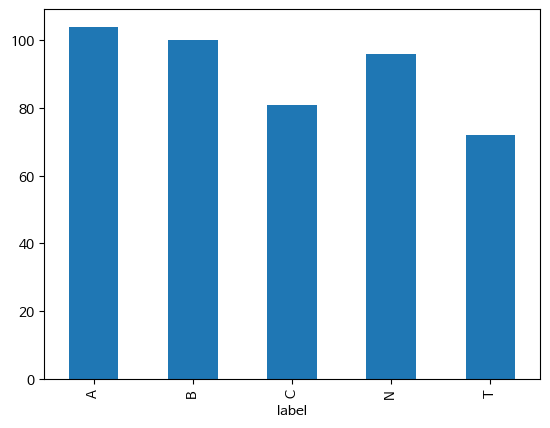

,id,label,text,tokens
0,1,B,올해에는 많은 부서들이 예산보다 초과 지출했다,"[올해, 부서, 예산, 초과, 지출]"
1,2,B,그 사업을 위한 예산으로 억원이 책정되어 있다,"[그, 사업, 위, 예산, 억원, 책정]"
2,3,B,우리는 예산이 아주 빠듯하다,"[우리, 예산, 아주, 빠듯하]"
3,4,B,그 부서의 예산은 손댈 수 없다,"[그, 부서, 예산, 수]"
4,5,B,우리가 올해는 예산보다 돈을 덜 썼다,"[우리, 올해, 예산, 돈, 덜]"
...,...,...,...,...
448,449,C,이 제품과 비교제품의 차이점을 자세히 알고 싶습니다,"[이, 제품, 비교, 제품, 차이점, 알]"
449,450,C,이 제품은 비교제품에 비해 어떤 점이 더 다른가요,"[이, 제품, 비교, 제품, 점, 더, 가요]"
450,451,C,제가 검토한 비교 제품과 이 제품을 비교해보면 어떤 차이가 있나요,"[제, 검토, 비교, 제품, 이, 제품, 비교, 차이]"
451,452,C,비교제품 대비 제가 이 제품을 구매해야 하는 이유가 무엇인가요,"[비교, 제품, 대비, 제, 이, 제품, 구매, 이유, 무엇]"


In [84]:
# prompt: matplotlib 으로 barchart를 그리는 방법
import matplotlib.pyplot as plt

df.groupby('label').size().plot(kind='bar')
plt.show()

df_B = df[df['label'] == 'B']
df_A = df[df['label'] == 'A']
df_N = df[df['label'] == 'N']
df_T = df[df['label'] == 'T']
df_C = df[df['label'] == 'C']

df

In [124]:
# tokenize
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

#print("sklearn version is", sklearn.__version__)
tokenizer = Okt()

#전체 데이터에 대한 tf-idf를 구하려면 아래 코드 실행
true_corpus = " ".join(df['text'].values)
df_B_corpus = " ".join(df_B['text'].values)
df_A_corpus = " ".join(df_A['text'].values)
df_N_corpus = " ".join(df_N['text'].values)
df_T_corpus = " ".join(df_T['text'].values)
df_C_corpus = " ".join(df_C['text'].values)
print(df_B_corpus)
print(df_N_corpus)


#tfidf_vector = TfidfVectorizer(tokenizer=tokenizer.nouns, min_df=2).fit([df_B_corpus, df_A_corpus, df_N_corpus, df_T_corpus, df_C_corpus])
#tfidf_result = tfidf_vector.transform([df_B_corpus, df_A_corpus, df_N_corpus, df_T_corpus, df_C_corpus])
#tfidf_result = tfidf_vector.transform([df_C_corpus])
tfidf_vector = TfidfVectorizer(tokenizer=tokenizer.nouns, min_df=1).fit([true_corpus])
tfidf_result = tfidf_vector.transform([true_corpus])
#vocab = tfidf_vector.vocabulary_
vocab = tfidf_vector.get_feature_names_out()
#print("vocab for debugging \n", vocab)

len(vocab)

올해에는 많은 부서들이 예산보다 초과 지출했다  그 사업을 위한 예산으로 억원이 책정되어 있다 우리는 예산이 아주 빠듯하다 그 부서의 예산은 손댈 수 없다 우리가 올해는 예산보다 돈을 덜 썼다  그 예산에는 느슨한 부분이 극히 적다  우리 부서가 예산 삭감으로 한 방 맞았다  우리가 신경 써서 예산을 짜면 그 여행비를 마련할 수 있을 거예요  예산 총액이 주요 걸림돌입니다  예산을 더 잘 짜봐야겠어  예산에는 여유가 거의 없다  우리는 견본 개발을 위한 많은 예산을 가지고 있다  그 프로젝트는 자세히 비용 산출을 할 필요가 있다  이 제안서들에 대한 비용 산출을 이미 다 하셨습니까  비용은 무시해도 될 정도였다  그것의 주된 문제점은 비용이다  비용은 최소한도를 유지해야 한다  이제 비용 문제로 넘어가야겠군요  회사가 그녀의 청구 금액을 지불하기를 거부하고 있다  이 부서가 올해 한도 금액보다 더 많은 돈을 지출할지도 모르겠다  근본적인 전제는 이용 가능한 금액이 제한되어 있다는 것이다  강연 초빙에 정해진 금액이 있으면 말씀해주십시오  귀하의 초청과 제시하신 금액을 기쁘게 수락하겠습니다  망설일 여지가 없어요 이 집을 원하신다면 오늘 원하시는 금액을 제시하셔야 해요  그들은 요금의 액수에 대해 항의를 했다  들어가기 전에 요금을 내도록 되어 있어요  그들이 청구한 요금 일부는 믿을 수가 없을 거예요 이건 순 날강도라니까요  우리가 돈을 내려 하면 바로 전에 갑자기 돈이 없다고 해  필요하면 돈은 있다  돈 가진 것이 있니  싸구려를 사면 돈만 버린다  우리는 돈이 필요했지만 당장에 들어올 돈은 없었다  이것은 고심해서 모은 돈이다 그 회사는 자금력이 엄청나다  지금 당장은 나에게 자금이 부족하다  우리 계획은 자금 부족으로 실현되지 못했다  프로젝트를 위한 자금을 구하다 그들이 더 많은 자금을 구하고는 있지만 돈이 없다  그 사업을 위한 자금은 지방 정부를 통해 지급될 것이다  감당할 수 있는 가격 우리가 가격에 동의하는 거죠  그 아파트는 가격이 적정하다 

874

In [97]:
# tfidf
i = 0
tfidf_words = tfidf_result.toarray().argsort()
#for i in range(5):
#    print(tfidf_words[i])  # tokens
#    print(len(tfidf_words[i]))

#tfidf_words[0] : true_corpus의 tf-idf 결과
#tfidf_words[1] : false_corpus의 tf-idf 결과
true_words = tfidf_words[0][::-1]  # reverse order
print (true_words[:10])

for word_index in true_words[:10]:
    print(vocab[word_index])

print(len(vocab))

[113 430 581 675  39  49 827 549 868 176]
그
수
이
제품
것
결정
프로젝트
우리
회사
다른
874


In [98]:
real_true_words = []

for word_index in true_words:
  word = vocab[word_index]
  if len(word) >= 2:
    real_true_words.append(word)

print(len(real_true_words))
#real_true_words = real_true_words[:500]
print(real_true_words[:20])

750
['제품', '결정', '프로젝트', '우리', '회사', '다른', '계약', '대한', '비교', '제안', '저희', '예산', '비용', '만료', '권한', '관심', '가격', '기간', '위해', '이번']


## 3) tokenization

In [54]:
from konlpy.tag import Okt

#print("sklearn version is", sklearn.__version__)
tokenizer = Okt()

# tokenizing nouns only
df['tokens'] = df['text'].apply(tokenizer.nouns)
df#['tokens']

,id,label,text,tokens
0,1,B,올해에는 많은 부서들이 예산보다 초과 지출했다,"[올해, 부서, 예산, 초과, 지출]"
1,2,B,그 사업을 위한 예산으로 억원이 책정되어 있다,"[그, 사업, 위, 예산, 억원, 책정]"
2,3,B,우리는 예산이 아주 빠듯하다,"[우리, 예산, 아주, 빠듯하]"
3,4,B,그 부서의 예산은 손댈 수 없다,"[그, 부서, 예산, 수]"
4,5,B,우리가 올해는 예산보다 돈을 덜 썼다,"[우리, 올해, 예산, 돈, 덜]"
...,...,...,...,...
448,449,C,이 제품과 비교제품의 차이점을 자세히 알고 싶습니다,"[이, 제품, 비교, 제품, 차이점, 알]"
449,450,C,이 제품은 비교제품에 비해 어떤 점이 더 다른가요,"[이, 제품, 비교, 제품, 점, 더, 가요]"
450,451,C,제가 검토한 비교 제품과 이 제품을 비교해보면 어떤 차이가 있나요,"[제, 검토, 비교, 제품, 이, 제품, 비교, 차이]"
451,452,C,비교제품 대비 제가 이 제품을 구매해야 하는 이유가 무엇인가요,"[비교, 제품, 대비, 제, 이, 제품, 구매, 이유, 무엇]"


## 4) word2vec model

In [6]:
# skip-gram model
from gensim.models import Word2Vec
# 파라메터 설명(https://radimrehurek.com/gensim/models/word2vec.html)
#sentences : 학습에 사용될 문장들 혹은 토크나이징 된 문장들
#vector_size : 벡터의 차원(크기)
#window : 모델이 단어의 관계성을 따지는 window 크기
#min_count : 이 횟수 이하로 언급된 단어는 제외함
#sg : 1일 때 skip-gram, 그 외에는 CBOW
skipgram_model = Word2Vec(sentences = df['tokens'], vector_size = 30, window = 5, min_count = 3, sg = 1)  # default alpha = 0.025
skipgram_model.wv.similar_by_word('예산')

[('입찰', 0.5839346647262573),
 ('이번', 0.5449602603912354),
 ('정보', 0.46185585856437683),
 ('외', 0.4573811888694763),
 ('요', 0.45561864972114563),
 ('제안', 0.4548802375793457),
 ('제품', 0.4512391984462738),
 ('할인', 0.4442804753780365),
 ('비용', 0.44361013174057007),
 ('두', 0.4388623833656311)]

In [7]:
# skipgram_model.wv.get_vector('예산')

In [8]:
# CBOW(continuous bag of words) model
#cbow_model = Word2Vec(sentences = df['tokens'], vector_size = 30, window = 5, min_count = 5, sg = 0)
#cbow_model.wv.similar_by_word('예산')

## 5) pre-training

In [9]:
# pretraining model
import gensim
#print(gensim.__version__)
#pre_model = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/ko.bin')
pre_model_df = pd.read_table('/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/ratings.txt')
#pre_model_df  # id\t document\t label

pre_model_df['document'] = pre_model_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
pre_model_df['document'] = pre_model_df['document'].str.replace(" +"," ")
#pre_model_df#['documet']


# tokenizing nouns only
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer

tokenizer = Okt()
pre_model_df['tokens'] = pre_model_df['document'].astype(str).apply(tokenizer.nouns)
#print(pre_model_df#['tokens'])
pre_model_df

<ipython-input-9-22cde12170ff>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  pre_model_df['document'] = pre_model_df['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
<ipython-input-9-22cde12170ff>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  pre_model_df['document'] = pre_model_df['document'].str.replace(" +"," ")


,id,document,label,tokens
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1,"[때, 보고, 지금, 다시]"
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1,"[디자인, 학생, 외국, 디자이너, 그, 일군, 전통, 통해, 발전, 문화, 산업,..."
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1,"[폴리스스토리, 시리즈, 부터, 뉴, 하나, 최고]"
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1,"[연기, 진짜, 개, 생각, 몰입, 진짜, 영화]"
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1,"[안개, 밤하늘, 초승달, 영화]"
...,...,...,...,...
199995,8963373,포켓 몬스터 짜가 ㅡㅡ,0,"[포켓, 몬스터]"
199996,3302770,쓰 레 기,0,"[레, 기]"
199997,5458175,완전 사이코영화 마지막은 더욱더 이 영화의질을 떨어트린다,0,"[완전, 사이코, 영화, 마지막, 더욱더, 이, 영화, 질, 트, 린다]"
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0,"[왜, 라따뚜이, 스머프, 런가]"


In [10]:
# ratings.txt로 1차 모델을 학습
from gensim.models import Word2Vec
pre_skipgram_model = Word2Vec(sentences = pre_model_df['tokens'], vector_size = 30, window = 5, min_count = 3, sg = 1, alpha=0.025, min_alpha=0.001)

# 저장하기
pre_skipgram_model.save("pre_skipgram_w2v.model")
# 불러오기
#model = Word2Vec.load("pre_skipgram_w2v.model")

pre_skipgram_model.wv.similar_by_word('예산')

[('독립영화', 0.880965530872345),
 ('단편영화', 0.8746145367622375),
 ('안목', 0.8740411400794983),
 ('저예산영화', 0.8689018487930298),
 ('이정', 0.8667644262313843),
 ('비급', 0.8643173575401306),
 ('결과물', 0.8608487844467163),
 ('급', 0.8505680561065674),
 ('따름', 0.8459652066230774),
 ('성인영화', 0.837454617023468)]

In [11]:
# 추가학습
pre_skipgram_model_cs = Word2Vec.load("pre_skipgram_w2v.model")
#pre_skipgram_model_cs.train(df['tokens'].values, epochs=30, total_examples=len(df))
pre_skipgram_model_cs = Word2Vec(sentences = pre_model_df['tokens'], vector_size = 30, window = 5, min_count = 3, sg = 1, alpha=0.025, min_alpha=0.001, epochs=30)
pre_skipgram_model_cs.wv.similar_by_word('예산')

[('독립영화', 0.8155103921890259),
 ('투자', 0.8036372065544128),
 ('제작비', 0.799496054649353),
 ('블록버스터', 0.7896822094917297),
 ('단편영화', 0.7807205319404602),
 ('감안', 0.7609207630157471),
 ('저예산영화', 0.7557230591773987),
 ('볼케이노', 0.7519950270652771),
 ('비디오영화', 0.740166187286377),
 ('스릴러물', 0.7352980971336365)]

## 6) 시각화

In [116]:
# 시각화 테스트용
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

#한글 폰트 지정
plt.rc('font', family='NanumBarunGothic')

model = pre_skipgram_model  #pre_model

#환경 단어 500개, 환경이 아닌 단어 500개를 불러와서, 모델을 통해 vector로 변환
#test_set = (set(real_true_words[:500])) & set(model.wv.key_to_index.keys())
#print(len(real_true_words))
#print(len(model.wv.key_to_index.keys()))
#test_set = (set(real_true_words)) & set(model.wv.key_to_index.keys())
#print(len(test_set))
#test_words = list(test_set)

test_words = list((set(real_true_words)) & set(model.wv.key_to_index.keys()))
vecs = np.array([model.wv.get_vector(word) for word in test_words])

#T-SNE 모델을 가져와서, 각 단어 벡터를 (x,y)축의 2차원으로 변환
tsne_model = TSNE(n_components=2)
transformed = tsne_model.fit_transform(vecs)
xs = transformed[:,0]
ys = transformed[:,1]



[[  5.0466385 -12.6763315]
 [ 22.007505   -1.870693 ]
 [ 15.813122   -3.9015465]
 ...
 [ -8.787548    9.15671  ]
 [-14.921076   10.454142 ]
 [  4.265592   -5.7466946]]


In [ ]:
# t-SNE
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

#한글 폰트 지정
plt.rc('font', family='NanumBarunGothic')

model = pre_skipgram_model #skipgram_model cbow_model pre_skipgram_model

#500 words to vector
#test_words = list((set(real_true_words[:500] + real_false_words[:500])) & set(model.wv.vocab.keys()))
test_set = (set(real_true_words)) & set(model.wv.key_to_index.keys())
test_words = list(test_set)

vecs = np.array([model.wv.get_vector(word) for word in test_words])
#print(vecs)

#T-SNE 모델을 가져와서, 각 단어 벡터를 (x,y)축의 2차원으로 변환
tsne_model = TSNE(learning_rate=100)
transformed = tsne_model.fit_transform(vecs)
xs = transformed[:,0]
ys = transformed[:,1]

#그래프에 흰색으로 점찍기
plt.figure(figsize=(20,20))
plt.scatter(xs, ys, c='w')

for idx, (x, y) in enumerate(transformed):
    #단어 찾기
    word = test_words[idx]
    #print(idx, x, y, word)

    #단어의 색깔 지정
    font_color = 'black'
    if word in real_true_words[:300]:
        font_color = 'b'
    #else:
    #    font_color = 'r'
#    elif word in real_false_words[:300]:
#        font_color = 'r'

    #(x,y)자리에 단어 표기
    plt.annotate(word, (x, y), fontsize=12, c=font_color)

plt.savefig("pre_model.png")
plt.show()

## 7) 실습; word2vec + decision tree

a. 환경 설정
b. data load
c. 한글 전처리
d. tokenization
e. word2vec; one-hot encoding, word2vec average embedding

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [47]:
model = pre_skipgram_model

train_avg_vectors = []
for tokens in df['tokens'].values:
    vecs = []
    for word in tokens:
        if word in model.wv.key_to_index.keys():
            vecs.append(model.wv.get_vector(word))
    train_avg_vectors.append(np.mean(vecs, axis=0))

#np.array(train_avg_vectors).shape
train_avg_vectors = np.array(train_avg_vectors)
train_avg_vectors.shape

<ipython-input-47-d661c825959d>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_avg_vectors = np.array(train_avg_vectors)


(453,)

In [64]:
# 테스트셋도 동일하게 임베딩
#데이터 로드
testData = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/test_set.xls")

#전처리
testData['text'] = testData['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
testData['text'] = testData['text'].str.replace(" +"," ")

#토크나이징
testData['tokens'] = testData['text'].astype(str).apply(tokenizer.nouns)

test_avg_vectors = []
for tokens in testData['tokens'].values:
    vecs = []
    for word in tokens:
        if word in model.wv.key_to_index.keys():
            vecs.append(model.wv.get_vector(word))
    test_avg_vectors.append(np.mean(vecs, axis=0))

test_avg_vectors = np.array(test_avg_vectors)
test_avg_vectors.shape

<ipython-input-64-3f75024ea24b>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  testData['text'] = testData['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
<ipython-input-64-3f75024ea24b>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  testData['text'] = testData['text'].str.replace(" +"," ")
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-64-3f75024ea24b>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

(467,)

In [ ]:
testData = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/nlp/kyobonlp/test_set.xls")

testData['text'] = testData['text'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]"," ")
testData['text'] = testData['text'].str.replace(" +"," ")

testData['tokens'] = testData['text'].astype(str).apply(tokenizer.nouns)

#test_avg_vectors = []

testData['tokens'].values

In [66]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

n_fold = 5
n_class = 5

cv = StratifiedKFold(n_splits=n_fold, shuffle=True)

In [68]:
p = np.zeros((df.shape[0], n_class))
p_tst = np.zeros((testData.shape[0], n_class))

for i_cv, (i_trn, i_val) in enumerate(cv.split(train_avg_vectors, df['label']), 1):
    clf = DecisionTreeClassifier(min_samples_split=50)
    clf.fit(train_avg_vectors[i_trn], df['label'][i_trn])
    p[i_val, :] = clf.predict_proba(train_avg_vectors[i_val])
    p_tst += clf.predict_proba(test_avg_vectors) / n_class #테스트 셋에 대해서도 예측
    print(f"Fold {i_cv} complete")

print(f'Accuracy (CV): {accuracy_score(df.label.values, np.argmax(p, axis=1)) * 100}%')
print(f'Accuracy (test): {accuracy_score(testData.label.values, np.argmax(p_tst, axis=1)) * 100}%')

ValueError: ignored

## comment

* word2vec은 자연어 처리의 기본 개념을 파악하는데 도움이 되지만, 단어의 순서를 고려하지 않으므로, 출현하는 단어가 같으면 의미가 반대여도 유사하다고 판단할 수 있음. 즉, 성능면에서 좋은 방법은 아님
* labeled test data가 없어, test data에 대한 평가를 할 수 없음
* 보다비에서 정답 데이터가 [label, text]의 형태로 오면 평가를 할 수 있을 듯
* 학습을 위한 데이터 양이 너무 적음
* 기본적인 개념이 파악되면, doc2vec, kobert 등 다른 방법을 시도해 보는 것이 좋겠음



